** Newer version at [https://github.com/oduerr/dl_tutorial/tree/master/lasagne] **

### Manipulating the training data on the fly
In this notebook we try to show how to avoid overfitting by augmenting the training data. 


We use a rather small dataset to illustate the effect of overfitting.

In [1]:
dataSize = 2000
epochs = 200

#### Loading the data
We load the net and data from the last session via the import.

In [2]:
from load_mnist import load_data_2d
X,y,PIXELS = load_data_2d('../../data/mnist.pkl.gz')

Couldn't import dot_parser, loading of dot files will not be possible.
Loaded data
After Batchnormalization (Pixelwise z-Trafo) Min / Max X / Mean -1.2488 / 66.487 / 8.03533e-10


Using gpu device 1: GeForce GTX 780


### Rescaling 
TODO

In [3]:
import numpy as np

#maxs = np.max(X[:,0,:,:],axis=(1,2))
#mins = np.min(X[:,0,:,:],axis=(1,2))
#Xs = np.zeros_like(X)
#for i in range(len(X)):
#    Xs[i,0,:,:] = (X[i,0,:,:] - maxs[i])/(maxs[i]-mins[i])
#X = Xs

Xs = (X - np.min(X)) / (np.max(X) - np.min(X))
X = Xs * 256.0    
np.min(X),np.max(X)

(0.0, 256.0)

### Defining the network
We use the standart network again.

In [4]:
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

def createNet():
   return NeuralNet(
        # Geometry of the network
        layers=[
            ('input', layers.InputLayer),
            ('conv1', layers.Conv2DLayer),
            ('pool1', layers.MaxPool2DLayer),
            ('conv2', layers.Conv2DLayer),
            ('pool2', layers.MaxPool2DLayer),
            ('hidden4', layers.DenseLayer),
            ('output', layers.DenseLayer),
            ],
        input_shape=(None, 1, PIXELS, PIXELS), #None in the first axis indicates that the batch size can be set later
        conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_ds=(2, 2),
        conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_ds=(2, 2),
        hidden4_num_units=500,
        output_num_units=10, output_nonlinearity=nonlinearities.softmax,

        # learning rate parameters
        update_learning_rate=0.01,
        update_momentum=0.90,
        regression=False,
        # We only train for 10 epochs
        max_epochs=epochs,
        verbose=1,

        # Training test-set split
        eval_size = 0.2
        )

In [5]:
netnoAug = createNet()
d = netnoAug.fit(X[0:dataSize,:,:,:],y[0:dataSize]); #Training with only 1000 examples

  InputLayer        	(None, 1, 28, 28)   	produces     784 outputs
  Conv2DLayer       	(None, 32, 26, 26)  	produces   21632 outputs
  MaxPool2DLayer    	(None, 32, 13, 13)  	produces    5408 outputs
  Conv2DLayer       	(None, 64, 12, 12)  	produces    9216 outputs
  MaxPool2DLayer    	(None, 64, 6, 6)    	produces    2304 outputs
  DenseLayer        	(None, 500)         	produces     500 outputs
  DenseLayer        	(None, 10)          	produces      10 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    1.470093  |    0.633373  |     2.321052  |     79.01%  |  0.3s
     2  |    0.584886  |    0.365219  |     1.601467  |     88.44%  |  0.3s
     3  |    0.260670  |    0.325720  |     0.800288  |     90.00%  |  0.3s
     4  |    0.158947  |    0.279724  |     0.568228  |     90.39%  |  0.3s
     5  |    0.107337  |    0.260560  |     0.411948  |     91.51%  |  0.3

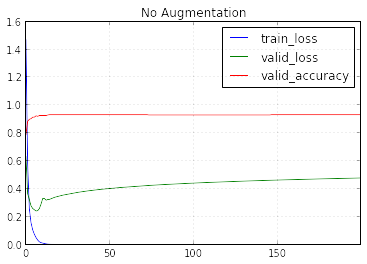

In [6]:
%matplotlib inline
import pandas as pd
dfNoAug = pd.DataFrame(netnoAug.train_history_)
dfNoAug[['train_loss','valid_loss','valid_accuracy']].plot(title='No Augmentation')

We see a clear overfitting the training loss drops towards 0 but after approximately 10 epochs the validation error rises again. This is a clear sign of overfitting.

This is not astonishing since we only have $300 \cdot 80=240$ training examples for each number. We are now trying to create new training data on the fly by performing manipulations. 


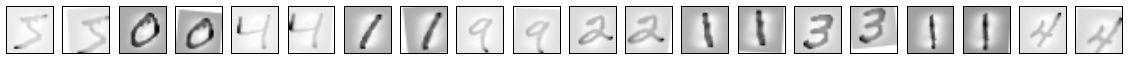

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import numpy as np
from skimage import transform as tf

rots = np.asarray((-6,-5,-4,-3,3,4,5,6)) / (360 / (2.0 * np.pi))
dists = (-2,-1,1,2)

def manipulateTrainingData(Xb):
    retX = np.zeros((Xb.shape[0], Xb.shape[1], Xb.shape[2], Xb.shape[3]), dtype='float32')
    for i in range(len(Xb)):
        dist = dists[np.random.randint(0, len(dists))]
        rot = rots[np.random.randint(0, len(rots))]
        scale = np.random.uniform(0.9,1.10)
        tform = tf.SimilarityTransform(rotation=rot, translation=dist, scale=scale)
        retX[i,0,:,:] = 256.0 * tf.warp(Xb[i,0,:,:]/256.0,tform) # "Float Images" are only allowed to have values between -1 and 1
    return retX


Xb = np.copy(Xs[0:100,:,:,:])
Xb = manipulateTrainingData(Xb)

fig = plt.figure(figsize=(20,150))
for i in range(10):
    a=fig.add_subplot(1,20,2*i+1,xticks=[], yticks=[])
    plt.imshow(-Xs[i,0,:,:], cmap=plt.get_cmap('gray'))
    a=fig.add_subplot(1,20,2*i+2,xticks=[], yticks=[])
    plt.imshow(-Xb[i,0,:,:], cmap=plt.get_cmap('gray'))    


#### Custom BatchIterator
Now we create our own using the transformations from above.

In [8]:
from nolearn.lasagne import BatchIterator

class SimpleBatchIterator(BatchIterator):

    def transform(self, Xb, yb):
        # The 'incomming' and outcomming shape is (10, 1, 28, 28)
        Xb, yb = super(SimpleBatchIterator, self).transform(Xb, yb)
        return manipulateTrainingData(Xb), yb #<--- Here we do the manipulations of the training set

# Setting the new batch iterator
net1Aug = createNet()
net1Aug.batch_iterator_train = SimpleBatchIterator(100)
d = net1Aug.fit(X[0:dataSize,:,:,:],y[0:dataSize])

  InputLayer        	(None, 1, 28, 28)   	produces     784 outputs
  Conv2DLayer       	(None, 32, 26, 26)  	produces   21632 outputs
  MaxPool2DLayer    	(None, 32, 13, 13)  	produces    5408 outputs
  Conv2DLayer       	(None, 64, 12, 12)  	produces    9216 outputs
  MaxPool2DLayer    	(None, 64, 6, 6)    	produces    2304 outputs
  DenseLayer        	(None, 500)         	produces     500 outputs
  DenseLayer        	(None, 10)          	produces      10 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    2.341876  |    1.623504  |     1.442482  |     55.68%  |  0.6s
     2  |    1.716305  |    0.792912  |     2.164558  |     80.67%  |  0.6s
     3  |    1.267452  |    0.566180  |     2.238604  |     84.14%  |  0.6s
     4  |    1.029407  |    0.473541  |     2.173850  |     86.48%  |  0.6s
     5  |    0.770027  |    0.395476  |     1.947088  |     89.95%  |  0.6

We also see that it takes a bit longer (0.4 sec), which is strange since in theory the flipping should be done on the CPU while the GPU is buisy doing the fitting. Maybe the network is not big enough to keep the GPU buissy? Anyway.

The second observation is that the performance drops from approx 80% to approx 40%. The reason is that maybe its not such a good idea to flip the training data in the first place. Any idea why?

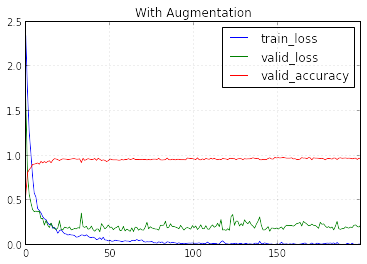

In [9]:
dfAug = pd.DataFrame(net1Aug.train_history_)
dfAug[['train_loss','valid_loss','valid_accuracy']].plot(title='With Augmentation')

### Nicer Plotting with ggplot2
Just a small detour, if you have R installed you can make nice plots (using e.g. ggplot)

In [13]:
%load_ext rpy2.ipython
%Rpush dfAug
%Rpush dfNoAug

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


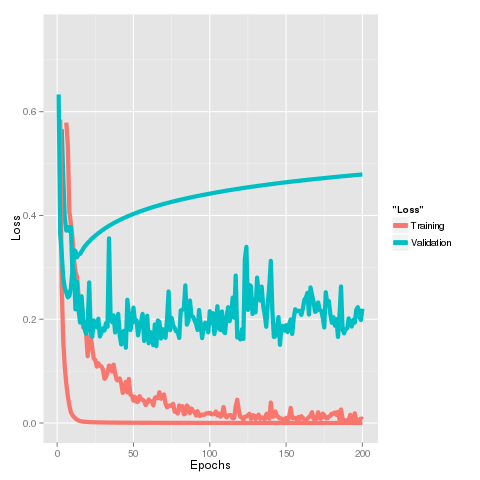

In [23]:
%%R
library(ggplot2)
ggplot() + aes(x=epoch, colour='Loss') + 
  geom_line(data=dfAug, aes(y = train_loss, colour='Training'), size=2) + 
  geom_line(data=dfAug, aes(y = valid_loss, colour='Validation'), size=2) + 
  geom_line(data=dfNoAug, aes(y = train_loss, colour='Training'), size=2) + 
  geom_line(data=dfNoAug, aes(y = valid_loss, colour='Validation'), size=2) + 
  xlab('Epochs') + ylab('Loss') +
  ylim(c(0,0.75))

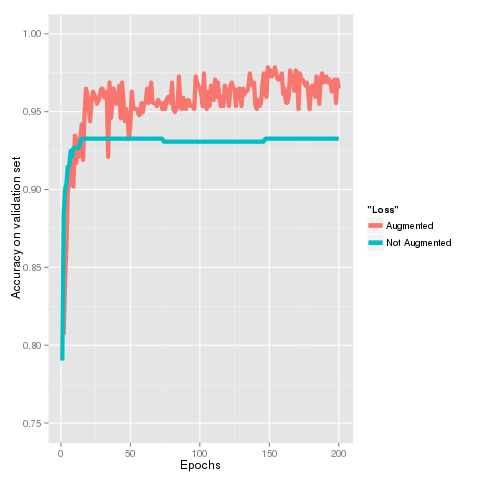

In [21]:
%%R
library(ggplot2)
ggplot() + aes(x=epoch, colour='Loss') + 
  geom_line(data=dfAug, aes(y = valid_accuracy, colour='Augmented'), size=2) + 
  geom_line(data=dfNoAug, aes(y = valid_accuracy, colour='Not Augmented'), size=2) + 
  xlab('Epochs') + ylab('Accuracy on validation set') +
  ylim(c(0.75,1))

If overwritting the `transform` method is not sufficient, one might even overwrite the `__iter__` method in the BatchIterator.